##  关键路径
- /data/ceiling/workspace/DLBLC/results/SZ
- /data/ceiling/workspace/DLBLC/results/Beijing
- /data/ceiling/workspace/DLBLC/results/LF
- /data/ceiling/workspace/DLBLC/results/SXH

# slide-level ROC-AUC计算

=== 5-Fold AUC (Mean with 95 %CI) ===
      BCL2: AUC=0.8245(0.7741–0.8750)
       MYC: AUC=0.8750(0.8104–0.9397)
      BCL6: AUC=0.7417(0.6467–0.8368)
  macro-avg: AUC=0.8138(0.7726–0.8549)


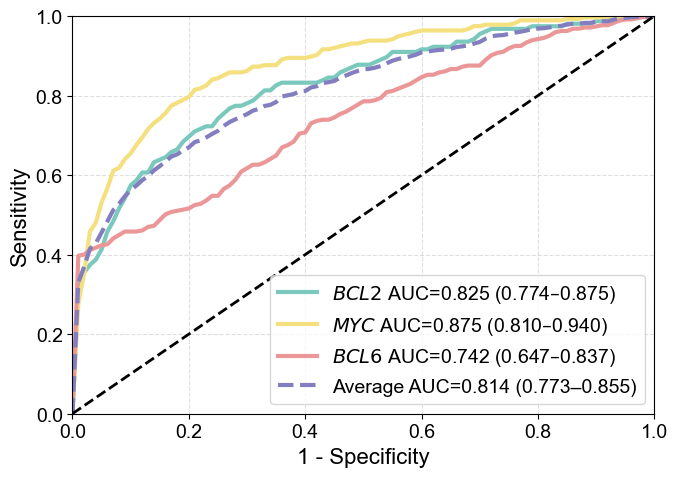

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn.metrics import roc_curve, auc

# --------------------------------------------------------------
# 设置全局字体为 Arial，坐标轴标题字号 14
# --------------------------------------------------------------
rcParams['font.family'] = 'Arial'
AXIS_LABEL_SIZE = 12

# --------------------------------------------------------------
# 1. 读取 5 个 csv
# --------------------------------------------------------------
center_name = 'SXH'
save_path   = f'./evaluation/{center_name}/{center_name}_ROC.png'
TEMPLATE    = f'./results/{center_name}/s_{{}}_checkpoint.csv'

dfs = [pd.read_csv(TEMPLATE.format(i)) for i in range(5)]

prob_cols  = [c for c in dfs[0].columns if c.startswith('prob_')]
label_cols = [c for c in dfs[0].columns if c.startswith('label_')]
colors     = ['#7AC9BC', '#F4E07E', '#EB9798', 'purple', 'cyan', 'magenta', 'red'] * 3

# --------------------------------------------------------------
# 工具函数：限制 95% CI 范围在 [0, 1]
# --------------------------------------------------------------
def bounded_ci(mean, std, z=1.96):
    lo = max(0.0, mean - z * std)
    hi = min(1.0, mean + z * std)
    return lo, hi

# --------------------------------------------------------------
# 2. 每折 ROC / AUC（macro-average）
# --------------------------------------------------------------
fpr_grid          = np.linspace(0, 1, 101)
fold_auc, fold_macro_auc = [], []
interp_tprs, interp_tprs_macro = [], []

for df in dfs:
    auc_dict, tpr_dict = {}, {}

    for prob_col, label_col in zip(prob_cols, label_cols):
        fpr, tpr, _ = roc_curve(df[label_col], df[prob_col])
        auc_dict[label_col] = auc(fpr, tpr)

        tpr_interp = np.interp(fpr_grid, fpr, tpr)
        tpr_interp[0], tpr_interp[-1] = 0.0, 1.0
        tpr_dict[label_col] = tpr_interp

    fold_auc.append(auc_dict)
    interp_tprs.append(tpr_dict)

    fold_macro_auc.append(np.mean(list(auc_dict.values())))
    interp_tprs_macro.append(np.vstack(list(tpr_dict.values())).mean(axis=0))

# --------------------------------------------------------------
# 3. 折间统计
# --------------------------------------------------------------
mean_auc = {lc: np.mean([d[lc] for d in fold_auc]) for lc in label_cols}
std_auc  = {lc: np.std ([d[lc] for d in fold_auc], ddof=1) for lc in label_cols}

mean_auc_macro = np.mean(fold_macro_auc)
std_auc_macro  = np.std (fold_macro_auc, ddof=1)

mean_tpr        = {lc: np.vstack([d[lc] for d in interp_tprs]).mean(axis=0)
                   for lc in label_cols}
mean_tpr_macro  = np.vstack(interp_tprs_macro).mean(axis=0)

# --------------------------------------------------------------
# 4. 打印结果（含 95 %CI，已裁剪至 [0,1]）
# --------------------------------------------------------------
print('=== 5-Fold AUC (Mean with 95 %CI) ===')
for lc in label_cols:
    m, s = mean_auc[lc], std_auc[lc]
    lo, hi = bounded_ci(m, s)
    print(f'{lc.replace("label_", ""):>10}: AUC={m:.4f}({lo:.4f}–{hi:.4f})')

m_macro, s_macro = mean_auc_macro, std_auc_macro
lo_macro, hi_macro = bounded_ci(m_macro, s_macro)
print(f'  macro-avg: AUC={m_macro:.4f}({lo_macro:.4f}–{hi_macro:.4f})')

# --------------------------------------------------------------
# 5. 绘图（加大字号、加粗曲线、95 %CI 图例，CI 同样裁剪）
# --------------------------------------------------------------
plt.figure(figsize=(7, 5))
plt.rcParams.update({
    'font.size': 14,
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14
})

for idx, lc in enumerate(label_cols):
    m, s = mean_auc[lc], std_auc[lc]
    lo, hi = bounded_ci(m, s)
    gene = r'$\mathit{' + lc.replace("label_", "") + '}$'
    plt.plot(fpr_grid, mean_tpr[lc],
             color=colors[idx], lw=3,
             label=f'{gene} AUC={m:.3f} ({lo:.3f}–{hi:.3f})')

lo_macro, hi_macro = bounded_ci(m_macro, s_macro)
plt.plot(fpr_grid, mean_tpr_macro,
         color='#827EC0', lw=3, linestyle='--',
         label=f'Average AUC={m_macro:.3f} ({lo_macro:.3f}–{hi_macro:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.legend(loc='lower right', frameon=True, shadow=False)
plt.grid(True, ls='--', alpha=0.4)
plt.tight_layout()
plt.savefig(save_path, dpi=300)
plt.show()

# slide-level PR-AUC 计算

=== 5-Fold AUPRC (Mean with 95 %CI) ===
      BCL2: AUPRC=0.6385(0.0000–1.0000)
       MYC: AUPRC=0.7626(0.3447–1.0000)
      BCL6: AUPRC=0.7277(0.4273–1.0000)
  macro-avg: AUPRC=0.7096(0.3933–1.0000)


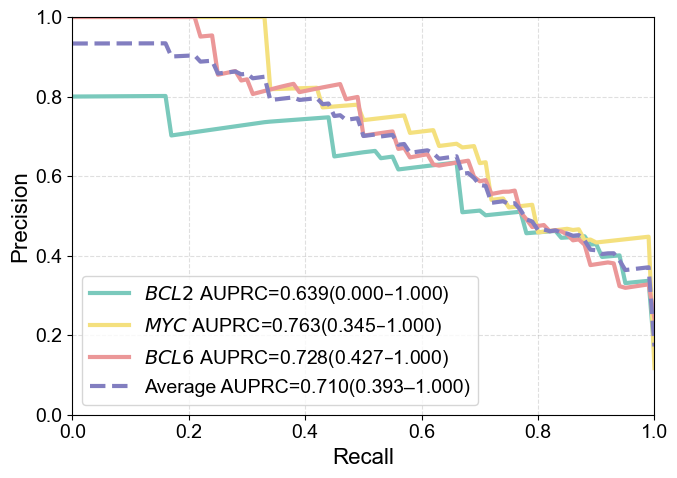

PR 曲线已保存至: ./evaluation/TCH_clinic/TCH_clinic_PR.pdf


In [2]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
5-fold mean Precision–Recall curves (macro-average)
Enhanced to match the ROC script style.
author: you
date  : 2025-06-26
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn.metrics import precision_recall_curve, average_precision_score
import os

# ----------------------------------------------------------
# 0. 全局设置（与 ROC 脚本完全一致）
# ----------------------------------------------------------
rcParams['font.family'] = 'Arial'
plt.rcParams.update({
    'font.size': 14,
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14
})

center_name = 'TCH_clinic'
TEMPLATE = f'./results/{center_name}/s_{{}}_checkpoint.csv'
save_path = f'./evaluation/{center_name}/{center_name}_PR.pdf'

N_FOLDS = 5
recall_grid = np.linspace(0, 1, 101)
colors = ['#7AC9BC', '#F4E07E', '#EB9798', 'purple', 'cyan', 'magenta', 'red'] * 3

# ----------------------------------------------------------
# 工具函数：限制 CI 范围在 [0, 1]
# ----------------------------------------------------------
def bounded_ci(mean, std, z=1.96):
    lo = max(0.0, mean - z * std)
    hi = min(1.0, mean + z * std)
    return lo, hi

# ----------------------------------------------------------
# 1. 读取 5 折
# ----------------------------------------------------------
dfs = [pd.read_csv(TEMPLATE.format(i)) for i in range(N_FOLDS)]
prob_cols  = [c for c in dfs[0].columns if c.startswith('prob_')]
label_cols = [c for c in dfs[0].columns if c.startswith('label_')]

# ----------------------------------------------------------
# 2. 每折 PR / AUPRC
# ----------------------------------------------------------
fold_auprc, fold_macro_auprc = [], []
interp_precs, interp_precs_macro = [], []

for df in dfs:
    auprc_dict, prec_dict = {}, {}
    for prob_c, label_c in zip(prob_cols, label_cols):
        precision, recall, _ = precision_recall_curve(df[label_c], df[prob_c])
        recall, precision = recall[::-1], precision[::-1]
        auprc_dict[label_c] = average_precision_score(df[label_c], df[prob_c])
        prec_interp = np.interp(recall_grid, recall, precision)
        prec_dict[label_c] = prec_interp

    fold_auprc.append(auprc_dict)
    interp_precs.append(prec_dict)

    fold_macro_auprc.append(np.mean(list(auprc_dict.values())))
    interp_precs_macro.append(np.vstack(list(prec_dict.values())).mean(axis=0))

# ----------------------------------------------------------
# 3. 5 折统计
# ----------------------------------------------------------
mean_auprc = {lc: np.mean([d[lc] for d in fold_auprc]) for lc in label_cols}
std_auprc  = {lc: np.std ([d[lc] for d in fold_auprc], ddof=1) for lc in label_cols}

mean_auprc_macro = np.mean(fold_macro_auprc)
std_auprc_macro  = np.std (fold_macro_auprc, ddof=1)

mean_prec = {lc: np.vstack([d[lc] for d in interp_precs]).mean(axis=0)
             for lc in label_cols}
mean_prec_macro = np.vstack(interp_precs_macro).mean(axis=0)

# ----------------------------------------------------------
# 4. 终端打印（CI 裁剪至 [0,1]）
# ----------------------------------------------------------
print('=== 5-Fold AUPRC (Mean with 95 %CI) ===')
for lc in label_cols:
    m, s = mean_auprc[lc], std_auprc[lc]
    lo, hi = bounded_ci(m, s)
    print(f'{lc.replace("label_", ""):>10}: AUPRC={m:.4f}({lo:.4f}–{hi:.4f})')

m_macro, s_macro = mean_auprc_macro, std_auprc_macro
lo_macro, hi_macro = bounded_ci(m_macro, s_macro)
print(f'  macro-avg: AUPRC={m_macro:.4f}({lo_macro:.4f}–{hi_macro:.4f})')

# ----------------------------------------------------------
# 5. 绘图
# ----------------------------------------------------------
plt.figure(figsize=(7, 5))

for idx, lc in enumerate(label_cols):
    m, s = mean_auprc[lc], std_auprc[lc]
    lo, hi = bounded_ci(m, s)
    gene = r'$\mathit{' + lc.replace("label_", "") + '}$'
    plt.plot(recall_grid, mean_prec[lc],
             color=colors[idx], lw=3,
             label=f'{gene} AUPRC={m:.3f}({lo:.3f}–{hi:.3f})')

lo_macro, hi_macro = bounded_ci(m_macro, s_macro)
plt.plot(recall_grid, mean_prec_macro,
         color='#827EC0', lw=3, linestyle='--',
         label=f'Average AUPRC={m_macro:.3f}({lo_macro:.3f}–{hi_macro:.3f})')

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left', frameon=True, shadow=False)
plt.grid(True, ls='--', alpha=0.4)
plt.tight_layout()

# ----------------------------------------------------------
# 6. 保存
# ----------------------------------------------------------
os.makedirs(os.path.dirname(save_path), exist_ok=True)
plt.savefig(save_path, dpi=300)
plt.show()
print(f'PR 曲线已保存至: {save_path}')

# slide-level 分类指标计算

In [59]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
5-fold multi-label metrics with per-label optimal threshold
+ save all outputs to a txt log
author : you
date   : 2025-06-26
"""

import sys
from pathlib import Path
import numpy as np
import pandas as pd
from contextlib import redirect_stdout
from sklearn.metrics import (confusion_matrix, precision_score, recall_score,
                             f1_score, roc_auc_score, average_precision_score,
                             roc_curve)

# ------------------------------------------------------------
# 0. 参数
# ------------------------------------------------------------
center_name = "TCH_clinic"
DATA_DIR    = Path(f"./results/{center_name}")
N_FOLDS     = 5
METRIC      = "youden"                                  # "youden" or "f1"
LOG_PATH    = Path(f"./evaluation/{center_name}/"
                   f"{center_name}_metrics.txt")

# ------------------------------------------------------------
# 0-bis. Tee：把 stdout 同时写入文件和终端
# ------------------------------------------------------------
class Tee:
    def __init__(self, *files):
        self.files = files
    def write(self, obj):
        for f in self.files:
            f.write(obj)
    def flush(self):
        for f in self.files:
            f.flush()

# ------------------------------------------------------------
# 1. 读取全部折
# ------------------------------------------------------------
dfs = [pd.read_csv(DATA_DIR / f"s_{i}_checkpoint.csv") for i in range(N_FOLDS)]

prob_cols  = [c for c in dfs[0].columns if c.startswith("prob_")]
label_cols = [c.replace("prob_", "label_") for c in prob_cols]
pred_cols  = [c.replace("prob_", "pred_")  for c in prob_cols]

assert set(label_cols).issubset(dfs[0].columns), "真值列缺失！"

# ------------------------------------------------------------
# 2. 工具函数：最佳阈值 & 二分类指标
# ------------------------------------------------------------
def best_threshold(y_true: np.ndarray, y_prob: np.ndarray, how: str = "youden") -> float:
    if how == "youden":
        fpr, tpr, thr = roc_curve(y_true, y_prob)
        return thr[np.argmax(tpr - fpr)]
    elif how == "f1":
        thresholds = np.r_[y_prob.min() - 1e-8, np.unique(y_prob)]
        best_t, best_f1 = 0.5, -1
        for t in thresholds:
            f1 = f1_score(y_true, (y_prob >= t).astype(int), zero_division=0)
            if f1 > best_f1:
                best_f1, best_t = f1, t
        return best_t
    else:
        raise ValueError("how must be 'youden' or 'f1'")

def binary_metrics(y_true, y_pred, y_prob):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    acc  = (tp + tn) / (tp + tn + fp + fn)
    sens = tp / (tp + fn) if (tp + fn) else np.nan
    spec = tn / (tn + fp) if (tn + fp) else np.nan
    prec = tp / (tp + fp) if (tp + fp) else np.nan
    f1   = f1_score(y_true, y_pred, zero_division=0)
    auroc = roc_auc_score(y_true, y_prob)               if len(np.unique(y_true)) == 2 else np.nan
    auprc = average_precision_score(y_true, y_prob)     if len(np.unique(y_true)) == 2 else np.nan
    return dict(ACC=acc, Sensitivity=sens, Specificity=spec,
                Precision=prec, F1=f1, AUROC=auroc, AUPRC=auprc,
                TP=tp, FP=fp, TN=tn, FN=fn)

# ------------------------------------------------------------
# 3. 主流程：逐折处理
# ------------------------------------------------------------
per_fold_class, per_fold_macro, per_fold_micro = [], [], []
per_fold_thr = []

for k, df in enumerate(dfs):
    # 3.1 每标签阈值
    thr_dict = {lc: best_threshold(df[lc].values, df[pc].values, METRIC)
                for pc, lc in zip(prob_cols, label_cols)}
    per_fold_thr.append(thr_dict)

    # 3.2 根据阈值→预测
    pred_df = pd.DataFrame({
        pc.replace("prob_", "pred_"): (df[pc] >= thr_dict[lc]).astype(int)
        for pc, lc in zip(prob_cols, label_cols)
    })

    # 3.3 逐标签指标
    recs = []
    for prob_c, label_c, pred_c in zip(prob_cols, label_cols, pred_cols):
        m = binary_metrics(df[label_c].values,
                           pred_df[pred_c].values,
                           df[prob_c].values)
        m["label"] = label_c.replace("label_", "")
        m["Thr"]   = thr_dict[label_c]
        recs.append(m)

    fold_df = pd.DataFrame(recs).set_index("label")
    per_fold_class.append(fold_df)

    # 3.4 macro / micro
    y_true = df[label_cols].values
    y_pred = pred_df.values
    per_fold_macro.append({
        "Precision": precision_score(y_true, y_pred, average="macro", zero_division=0),
        "Recall"   : recall_score   (y_true, y_pred, average="macro", zero_division=0),
        "F1"       : f1_score       (y_true, y_pred, average="macro", zero_division=0)})
    per_fold_micro.append({
        "Precision": precision_score(y_true, y_pred, average="micro", zero_division=0),
        "Recall"   : recall_score   (y_true, y_pred, average="micro", zero_division=0),
        "F1"       : f1_score       (y_true, y_pred, average="micro", zero_division=0)})

# ------------------------------------------------------------
# 4. 输出：同时写 txt + 终端
# ------------------------------------------------------------
LOG_PATH.parent.mkdir(parents=True, exist_ok=True)
with open(LOG_PATH, "w", encoding="utf-8") as f_log, redirect_stdout(Tee(sys.stdout, f_log)):

    for idx, df in enumerate(per_fold_class):
        print(f"\n========== Fold {idx} (best-{METRIC}) ==========")
        print(df[["Thr", "ACC", "Sensitivity", "Specificity",
                  "Precision", "F1", "AUROC", "AUPRC"]].round(4))
        print("Macro avg :", {k: f"{v:.4f}" for k, v in per_fold_macro[idx].items()})
        print("Micro avg :", {k: f"{v:.4f}" for k, v in per_fold_micro[idx].items()})

    # ---- 5-折汇总 ----
    cat      = pd.concat(per_fold_class, keys=range(N_FOLDS), names=["fold", "label"])
    mean_df  = cat.groupby("label").mean()
    std_df   = cat.groupby("label").std(ddof=1)

    print("\n========== 5-Fold Mean ± Std (per label) ==========")
    summary = mean_df.round(4).astype(str) + " ± " + std_df.round(4).astype(str)
    print(summary[["Thr", "ACC", "Sensitivity", "Specificity",
                   "Precision", "F1", "AUROC", "AUPRC"]])

    macro_df = pd.DataFrame(per_fold_macro)
    micro_df = pd.DataFrame(per_fold_micro)

    print("\n========== 5-Fold Macro Average ==========")
    for m in macro_df.columns:
        print(f"{m:>9}: {macro_df[m].mean():.4f} ± {macro_df[m].std(ddof=1):.4f}")

    print("\n========== 5-Fold Micro Average ==========")
    for m in micro_df.columns:
        print(f"{m:>9}: {micro_df[m].mean():.4f} ± {micro_df[m].std(ddof=1):.4f}")

print(f"\n所有结果已写入: {LOG_PATH}")


========== Fold 0 (best-youden) ==========
          Thr     ACC  Sensitivity  Specificity  Precision      F1   AUROC  \
label                                                                        
BCL2   0.0793  0.6393       1.0000       0.6333     0.0435  0.0833  0.6333   
MYC    0.1157  0.7377       1.0000       0.7241     0.1579  0.2727  0.8506   
BCL6   0.4214  0.8197       0.8889       0.7907     0.6400  0.7442  0.8798   

        AUPRC  
label          
BCL2   0.0435  
MYC    0.4415  
BCL6   0.8331  
Macro avg : {'Precision': '0.2805', 'Recall': '0.9630', 'F1': '0.3667'}
Micro avg : {'Precision': '0.2985', 'Recall': '0.9091', 'F1': '0.4494'}

========== Fold 1 (best-youden) ==========
          Thr     ACC  Sensitivity  Specificity  Precision      F1   AUROC  \
label                                                                        
BCL2   0.2676  0.9388       0.6667       0.9767     0.8000  0.7273  0.7519   
MYC    0.4614  1.0000       1.0000       1.0000     1.0000  1.0

# slide-level 单类别混淆矩阵

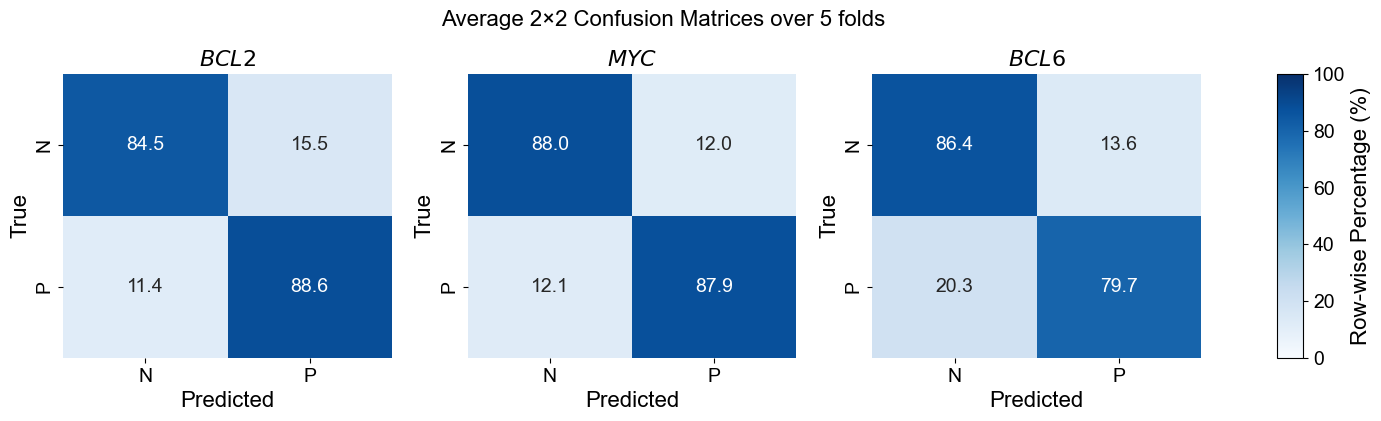

In [87]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
Draw 2×2 confusion matrices for BCL2 / MYC / BCL6 over 5 folds
author : you
date   : 2025-06-26
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.metrics import roc_curve, f1_score, confusion_matrix
# ---------- 0. 全局字体：Arial + 加大加粗 ----------
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 14,               # 基础字号
    'axes.labelsize': 16,          # 坐标轴标题
    'axes.titlesize': 16,          # 子图标题
    'xtick.labelsize': 14,         # 横轴刻度
    'ytick.labelsize': 14,         # 纵轴刻度
    'legend.fontsize': 14,
    # 加粗
    # 'axes.labelweight': 'bold',
    # 'axes.titleweight': 'bold',
    # 'font.weight': 'bold'
})

# ------------------------ 参数 ------------------------
center_name = "TCH_clinic"
N_FOLDS = 5
CSV_TPL  = "./results/{}/s_{}_checkpoint.csv"
METRIC   = "youden"           # "youden" or "f1"
FIG_PATH = f"./evaluation/{center_name}/{center_name}_avg_matrix_2cls.pdf"

LABELS = ["BCL2", "MYC", "BCL6"]

# ------------------ 1️⃣  工具函数 ------------------
def best_threshold(y_true, y_prob, how="youden"):
    if how == "youden":
        fpr, tpr, thr = roc_curve(y_true, y_prob)
        return thr[np.argmax(tpr - fpr)]
    elif how == "f1":
        best_t, best_f1 = 0.5, -1
        for t in np.r_[y_prob.min() - 1e-8, np.unique(y_prob)]:
            f1 = f1_score(y_true, (y_prob >= t).astype(int), zero_division=0)
            if f1 > best_f1:
                best_f1, best_t = f1, t
        return best_t

# ------------------ 2️⃣  累加 2×2 混淆矩阵 ------------------
cm_sum = {lab: np.zeros((2, 2), dtype=int) for lab in LABELS}

for fold in range(N_FOLDS):
    df = pd.read_csv(CSV_TPL.format(center_name, fold))
    for lab in LABELS:
        thr = best_threshold(df[f"label_{lab}"], df[f"prob_{lab}"], METRIC)
        y_true = df[f"label_{lab}"].astype(int).values
        y_pred = (df[f"prob_{lab}"] >= thr).astype(int).values
        cm_sum[lab] += confusion_matrix(y_true, y_pred, labels=[0, 1])

# ------------------ 3️⃣  行归一化 ------------------
cm_pct = {}
for lab, cm in cm_sum.items():
    row_sums = cm.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1
    cm_pct[lab] = cm / row_sums

# ------------------ 4️⃣  绘图 ------------------
cmap = sns.color_palette("Blues", as_cmap=True)
norm = plt.Normalize(vmin=0, vmax=100)

fig = plt.figure(figsize=(16, 4))
gs = fig.add_gridspec(1, 4, width_ratios=[1, 1, 1, 0.08], wspace=0.3)

axes    = [fig.add_subplot(gs[0, i]) for i in range(3)]
cbar_ax = fig.add_subplot(gs[0, 3])

for ax, lab in zip(axes, LABELS):
    sns.heatmap(cm_pct[lab] * 100,
                annot=True, fmt=".1f",
                cmap=cmap, norm=norm, cbar=False,
                xticklabels=["N", "P"], yticklabels=["N", "P"],
                ax=ax)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(r'$\mathit{' + lab + '}$')
# 独立颜色条
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=cbar_ax, label="Row-wise Percentage (%)")

# ① 把子图整体往下挪一点，给标题腾出空间
fig.subplots_adjust(top=0.82)      # 0.82 可按需要微调

# ② 再加标题
fig.suptitle("Average 2×2 Confusion Matrices over 5 folds",
             fontsize=16)

# ③ 保存时让 Matplotlib 自动把整个区域（含标题）都算进去
Path(FIG_PATH).parent.mkdir(parents=True, exist_ok=True)
fig.savefig(FIG_PATH,
            dpi=300,
            bbox_inches="tight",   # 关键①：自动扩展边界
            pad_inches=0.1)        # 关键②：再加 0.1 英寸留白
plt.show()

# 共现分析

In [12]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
计算三种共表达模式的 AUROC (mean + 95 %CI) 并保存为 Excel
路径：./evaluation/SXH_clinic/Pattern_AUROC_Stats.xlsx
"""
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from pathlib import Path

# ---------- 参数 ----------
center_name = "TCH_clinic"
N_FOLDS = 5
CSV_TPL = "./results/{}/s_{}_checkpoint.csv"
OUT_DIR = Path(f"./evaluation/{center_name}")
OUT_DIR.mkdir(parents=True, exist_ok=True)
EXCEL_PATH = OUT_DIR / "Pattern_AUROC_Stats.csv"

PATTERNS = {
    'BCL2+MYC':       {'BCL2': 1, 'MYC': 1, 'BCL6': 0},
    'BCL6+MYC':       {'BCL2': 0, 'MYC': 1, 'BCL6': 1},
    'BCL2+MYC+BCL6':  {'BCL2': 1, 'MYC': 1, 'BCL6': 1},
}

# ---------- 5 折 AUROC ----------
auroc_fold = {name: [] for name in PATTERNS}
for fold in range(N_FOLDS):
    df = pd.read_csv(CSV_TPL.format(center_name, fold))
    df['prob_joint'] = df[['prob_BCL2', 'prob_MYC', 'prob_BCL6']].mean(axis=1)
    for pname, rule in PATTERNS.items():
        y_true = np.all(df[['label_BCL2', 'label_MYC', 'label_BCL6']].astype(int) ==
                        [rule['BCL2'], rule['MYC'], rule['BCL6']], axis=1)
        if y_true.sum() == 0:
            continue
        auroc_fold[pname].append(roc_auc_score(y_true, df['prob_joint']))

# ---------- 整理 DataFrame ----------
df_out = pd.DataFrame({
    'Pattern': list(PATTERNS.keys()),
    'mean':    [np.mean(auroc_fold[n]) for n in PATTERNS],
    'ci_low':  [np.percentile(auroc_fold[n], 2.5) for n in PATTERNS],
    'ci_high': [np.percentile(auroc_fold[n], 97.5) for n in PATTERNS],
})

# ---------- 保存 Excel ----------
df_out.to_csv(EXCEL_PATH, index=False)
print(f"AUROC 统计已保存 → {EXCEL_PATH.resolve()}")

AUROC 统计已保存 → /data3/ceiling/workspace/DLBCL2/evaluation/TCH_clinic/Pattern_AUROC_Stats.csv


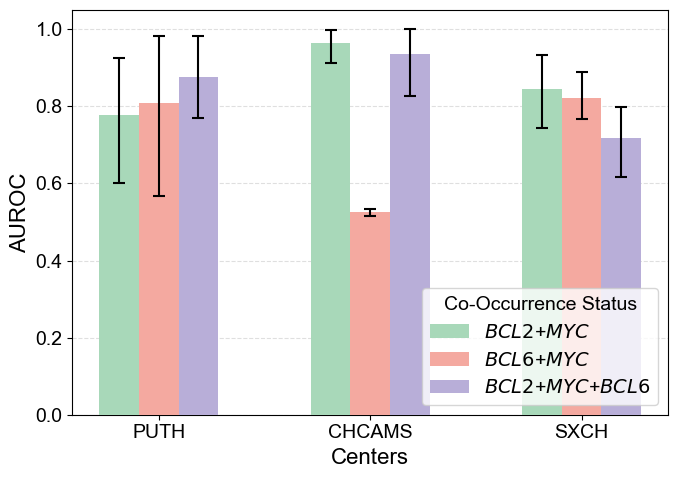

多中心 AUROC 柱状图（中心名已替换）已保存 → /data3/ceiling/workspace/DLBCL2/evaluation/multi_center_AUROC_bar.pdf


In [8]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
多中心 AUROC 柱状图（并排 + 组间空格）
95 %CI 强制 clip 在 [0.5, 1.0]
中心显示名称：BH→PUTH，TCH→CHCAMS，SXH→SXCH
--------------------------------------------------
改动点：
1. bar 无边框 edgecolor='none'
2. Legend 中 BCL2/BCL6/MYC 斜体
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

plt.rcParams.update({'font.family': 'Arial', 'font.size': 14,
                     'axes.labelsize': 16, 'xtick.labelsize': 14,
                     'ytick.labelsize': 14})

ROOT = Path("/data3/ceiling/workspace/DLBCL2/evaluation")
CENTERS = ['BH', 'TCH', 'SXH']          # 文件夹名不变
CENTER_DISP = {'BH': 'PUTH',
               'TCH': 'CHCAMS',
               'SXH': 'SXCH'}
PATTERNS = ['BCL2+MYC', 'BCL6+MYC', 'BCL2+MYC+BCL6']
COLORS   = ['#A8D8B9', '#F4A9A0', '#B8AED8']

# ---------- 读取数据 ----------
stats = []
for cen in CENTERS:
    df = pd.read_csv(ROOT / cen / "Pattern_AUROC_Stats.csv")
    for _, row in df.iterrows():
        stats.append({'Center': cen, 'Pattern': row['Pattern'],
                      'mean': row['mean'], 'ci_low': row['ci_low'], 'ci_high': row['ci_high']})
df_all = pd.DataFrame(stats)

# ---------- 位置计算 ----------
group_gap = 0.75
bar_width = 0.32
x_base = 0
positions = []
center_ticks = []
for cen_idx, cen in enumerate(CENTERS):
    start = x_base
    for pat_idx, _ in enumerate(PATTERNS):
        positions.append(x_base + pat_idx * bar_width)
    center_ticks.append(x_base + bar_width * (len(PATTERNS) - 1) / 2)
    x_base += len(PATTERNS) * bar_width + group_gap

# ---------- 画图 ----------
fig, ax = plt.subplots(figsize=(7, 5))
for pat_idx, pat in enumerate(PATTERNS):
    means = df_all[df_all['Pattern'] == pat]['mean'].values
    lows  = df_all[df_all['Pattern'] == pat]['ci_low'].values
    highs = df_all[df_all['Pattern'] == pat]['ci_high'].values

    lows  = np.clip(lows, 0.5, 1.0)
    highs = np.clip(highs, 0.5, 1.0)
    yerr  = np.array([means - lows, highs - means])
    x_pos = [positions[i * len(PATTERNS) + pat_idx] for i in range(len(CENTERS))]

    # 关键改动 1：去掉 bar 边框
    ax.bar(x_pos, means, width=bar_width, color=COLORS[pat_idx],
           edgecolor='none', label=pat, linewidth=0, zorder=3)
    ax.errorbar(x_pos, means, yerr=yerr, fmt='none', ecolor='black',
                capsize=4, capthick=1.5, zorder=4)

# ---------- 细节 ----------
ax.set_ylabel('AUROC')
ax.set_xlabel('Centers')
ax.set_xticks(center_ticks)
ax.set_xticklabels([CENTER_DISP[c] for c in CENTERS])
ax.set_ylim(0.0, 1.05)
ax.grid(axis='y', ls='--', alpha=0.4, zorder=0)

# 关键改动 2：Legend 斜体
# 用 mathtext 把 BCL2/BCL6/MYC 包在 $...$ 里即可斜体
legend_labels = [r'$\mathit{BCL2}$+$\mathit{MYC}$',
                 r'$\mathit{BCL6}$+$\mathit{MYC}$',
                 r'$\mathit{BCL2}$+$\mathit{MYC}$+$\mathit{BCL6}$']
handles, _ = ax.get_legend_handles_labels()   # 取出 3 个 BarContainer
ax.legend(handles=handles,
          labels=legend_labels,
          title='Co-Occurrence Status',
          loc='lower right')
plt.tight_layout()
SAVE_PATH = Path('/data3/ceiling/workspace/DLBCL2/evaluation/multi_center_AUROC_bar.pdf')
SAVE_PATH.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(SAVE_PATH, dpi=300, bbox_inches='tight')
plt.show()
print(f"多中心 AUROC 柱状图（中心名已替换）已保存 → {SAVE_PATH}")

# 生存分析曲线

# 单表达 prob os 

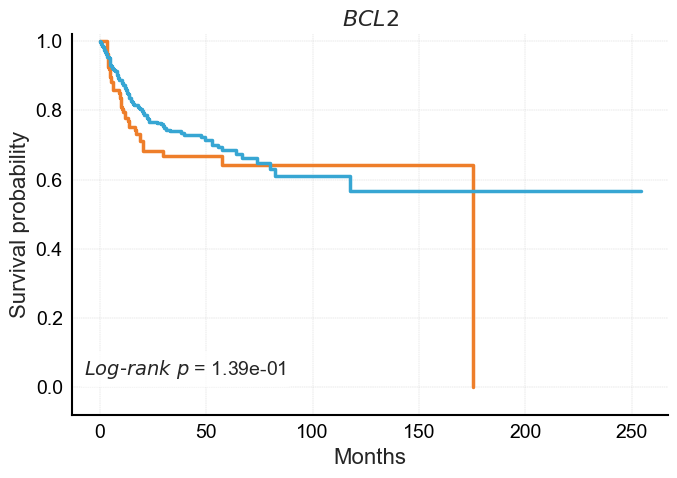

→ 完成：KM_BCL2_prob_fold4.pdf 已保存

---------- Risk table (first few rows) ----------
   time  High  Low
0     0   135  451
1    25    59  218
2    50    29  102
3    75    14   43
4   100     5   18
5   125     2   12
6   150     2    7
7   175     2    4
8   200     1    3
9   225     1    3
-----------------------------------------------
→ Risk table 已保存：evaluation/TCH_all/survival_singe_label_OS/RiskTable_BCL2_prob_fold4.csv


In [14]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
BH-TCH 生存分析（Overall Survival）
按模型预测风险（prob ≥ THR → High）分组，
一次性绘制 BCL2 / MYC / BCL6 共 3 张 KM 曲线。

依赖：
    pip install lifelines matplotlib pandas numpy openpyxl
"""

import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, statistics, CoxPHFitter
plt.rcParams.update({'font.family': 'Arial', 'font.size': 14,
                     'axes.labelsize': 16, 'xtick.labelsize': 14,
                     'ytick.labelsize': 14})

# --------------------------------------------------
# 0. 路径与参数
# --------------------------------------------------
fold        = 4
group_path  = './dataset_csv/BH_TCH(merge).xlsx'
pred_path   = f'./results/TCH_all/s_{fold}_checkpoint.csv'

out_dir     = Path('./evaluation/TCH_all/survival_singe_prob_OS')
out_dir.mkdir(parents=True, exist_ok=True)

TIME_COL   = 'OS(m)'       # 生存时间（月）
EVENT_COL  = 'OS Status'   # 1 = 死亡(事件)；0 = 存活/删失
THR        = 0.5           # 概率阈值
gene       = 'BCL2'                                  # 指定基因

# --------------------------------------------------
# 1. 读取并合并
# --------------------------------------------------
group_df = pd.read_excel(group_path)
pred_df  = pd.read_csv(pred_path)

df = pred_df.merge(
        group_df[['slide_id', TIME_COL, EVENT_COL]],
        on='slide_id', how='left'
     ).dropna(subset=[TIME_COL, EVENT_COL])

# --------------------------------------------------
# 2. 分组函数
# --------------------------------------------------
def risk_group(prob, thr=THR):
    try:
        return 'High' if float(prob) >= thr else 'Low'
    except (ValueError, TypeError):
        return np.nan

# ---------- 高级 KM + rug 替换区（原脚本第 3 步） ----------
import seaborn as sns
from matplotlib import rcParams

# ---------- 单基因（BCL2）高级 KM（无 rug）----------
import seaborn as sns
from matplotlib import rcParams

rcParams['font.family'] = 'Arial'
sns.set_style("whitegrid", {'axes.grid': False})

fig, ax = plt.subplots(1, 1, figsize=(7, 5))   # 单图
prob_col = f'prob_{gene}'
df[f'{gene}_risk'] = df[prob_col].apply(risk_group)
sub = df.dropna(subset=[f'{gene}_risk'])

palette = {'High': '#EE7E2A', 'Low': '#37A6D3'}

# 绘制 KM
for grp, g in sub.groupby(f'{gene}_risk'):
    kmf = KaplanMeierFitter()
    kmf.fit(g[TIME_COL], g[EVENT_COL], label=f'{grp} (N={len(g)})')
    ax.step(kmf.timeline, kmf.survival_function_.values, where='post',
            color=palette[grp], lw=2.5)
    # ax.fill_between(kmf.timeline,
    #                 kmf.confidence_interval_.iloc[:, 0],
    #                 kmf.confidence_interval_.iloc[:, 1],
    #                 color=palette[grp], alpha=0.15)

# log-rank p（科学计数法 + 大字体）
hi = sub.query(f'{gene}_risk=="High"')
lo = sub.query(f'{gene}_risk=="Low"')
lr_p = statistics.logrank_test(hi[TIME_COL], lo[TIME_COL],
                               hi[EVENT_COL], lo[EVENT_COL]).p_value
ax.text(0.02, 0.15, 
        r'$\it{Log{\text{-}}rank\ p}$' + f' = {lr_p:.2e}',
        transform=ax.transAxes,
        fontsize=14, verticalalignment='top',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

# 装饰
ax.set_title(r'$\mathit{' + gene + '}$', fontsize=16, style='italic')
ax.set_xlabel('Months')
ax.set_ylabel('Survival probability')
ax.set_ylim(-0.08, 1.02)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, axis='both', ls='--', lw=0.3, alpha=1.0)
# ↓↓↓ 加粗坐标轴 & 刻度 ↓↓↓
for spine in ['left', 'bottom']:
    ax.spines[spine].set_linewidth(1.5)
    ax.spines[spine].set_color('black')
ax.tick_params(width=1.5, colors='black')   # 刻度线黑色

plt.tight_layout()
plt.savefig(out_dir / f'KM_{gene}_prob_fold{fold}.pdf', dpi=300)
plt.show()
print(f'→ 完成：KM_{gene}_prob_fold{fold}.pdf 已保存')

# --------------------------------------------------
# 3. 生成并保存 risk table（Number at risk）
# --------------------------------------------------
risk_records = []          # 收集每一行
time_grid    = np.arange(0, int(sub[TIME_COL].max())+1, 25)  # 每 12 个月一个刻度，可改

for grp in ['Low', 'High']:
    g   = sub.query(f'{gene}_risk==@grp')
    kmf = KaplanMeierFitter()
    kmf.fit(g[TIME_COL], g[EVENT_COL], label=f'{grp}')
    
    # lifelines 自带 at-risk 表格
    atr = kmf.event_table[['at_risk']]
    atr = atr.reindex(time_grid, method='ffill').fillna(0).astype(int)
    atr['group'] = grp
    atr['time']  = atr.index
    risk_records.append(atr[['time', 'group', 'at_risk']])

risk_df = pd.concat(risk_records, ignore_index=True)\
          .pivot(index='time', columns='group', values='at_risk')\
          .rename_axis(None, axis=1)\
          .reset_index()

# 保存
risk_df.to_csv(out_dir / f'RiskTable_{gene}_prob_fold{fold}.csv', index=False)

print('\n---------- Risk table (first few rows) ----------')
print(risk_df.head(10))
print('-----------------------------------------------')
print(f'→ Risk table 已保存：'
      f'{out_dir}/RiskTable_{gene}_prob_fold{fold}.csv')


# 单表达 label os 

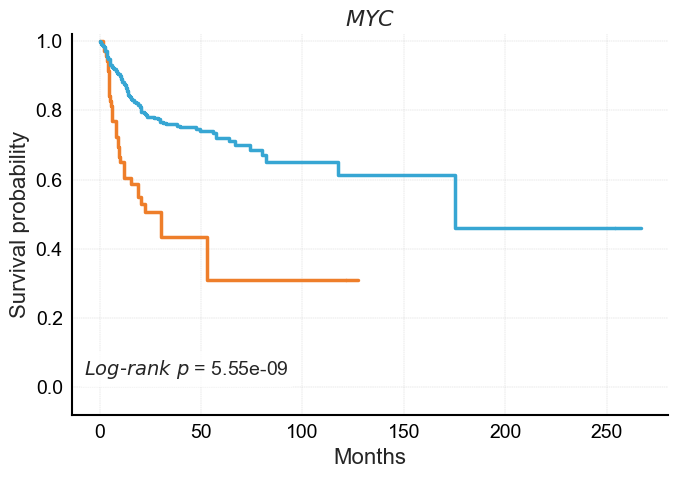

→ 完成：KM_MYC_label.pdf 已保存

---------- Risk table (first few rows) ----------
   time  High  Low
0     0    69  517
1    25    20  258
2    50     8  123
3    75     7   51
4   100     5   19
5   125     1   13
6   150     1    8
7   175     1    5
8   200     1    3
9   225     1    3
-----------------------------------------------
→ Risk table 已保存：evaluation/TCH_all/survival_singe_label_OS/RiskTable_MYC_label_fold4.csv


In [35]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
BH-TCH 生存分析（Overall Survival）
按模型预测风险（prob ≥ THR → High）分组，
一次性绘制 BCL2 / MYC / BCL6 共 3 张 KM 曲线。

依赖：
    pip install lifelines matplotlib pandas numpy openpyxl
"""  

import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, statistics, CoxPHFitter
plt.rcParams.update({'font.family': 'Arial', 'font.size': 14,
                     'axes.labelsize': 16, 'xtick.labelsize': 14,
                     'ytick.labelsize': 14})

# --------------------------------------------------
# 0. 路径与参数
# --------------------------------------------------
fold        = 4
group_path  = './dataset_csv/BH_TCH(merge).xlsx'
pred_path   = f'./results/TCH_all/s_{fold}_checkpoint.csv'

out_dir     = Path('./evaluation/TCH_all/survival_singe_label_OS')
out_dir.mkdir(parents=True, exist_ok=True)

TIME_COL   = 'OS(m)'       # 生存时间（月）
EVENT_COL  = 'OS Status'   # 1 = 死亡(事件)；0 = 存活/删失
THR        = 0.5           # 概率阈值
gene       = 'MYC'                                  # 指定基因

# --------------------------------------------------
# 1. 读取并合并
# --------------------------------------------------
group_df = pd.read_excel(group_path)
pred_df  = pd.read_csv(pred_path)

df = pred_df.merge(
        group_df[['slide_id', TIME_COL, EVENT_COL]],
        on='slide_id', how='left'
     ).dropna(subset=[TIME_COL, EVENT_COL])

# --------------------------------------------------
# 2. 分组函数
# --------------------------------------------------
def risk_group(prob, thr=THR):
    try:
        return 'High' if float(prob) >= thr else 'Low'
    except (ValueError, TypeError):
        return np.nan

# ---------- 高级 KM + rug 替换区（原脚本第 3 步） ----------
import seaborn as sns
from matplotlib import rcParams

# ---------- 单基因（BCL2）高级 KM（无 rug）----------
import seaborn as sns
from matplotlib import rcParams

rcParams['font.family'] = 'Arial'
sns.set_style("whitegrid", {'axes.grid': False})

fig, ax = plt.subplots(1, 1, figsize=(7, 5))   # 单图
prob_col = f'label_{gene}'
df[f'{gene}_risk'] = df[prob_col].apply(risk_group)
sub = df.dropna(subset=[f'{gene}_risk'])

palette = {'High': '#EE7E2A', 'Low': '#37A6D3'}

# 绘制 KM
# for grp, g in sub.groupby(f'{gene}_risk'):
#     kmf = KaplanMeierFitter()
#     kmf.fit(g[TIME_COL], g[EVENT_COL], label=f'{grp} (N={len(g)})')
#     ax.plot(kmf.timeline, kmf.survival_function_.values,
#             color=palette[grp], lw=2.5)
for grp, g in sub.groupby(f'{gene}_risk'):
    kmf = KaplanMeierFitter()
    kmf.fit(g[TIME_COL], g[EVENT_COL])

    t = kmf.timeline
    s = kmf.survival_function_.values.flatten()

    ax.step(t, s, where='post',
            color=palette[grp], lw=2.5,
            label=f'{grp} (N={len(g)})')

    # 可选：把最后一条横线拉到图右边
    ax.plot([t[-1], ax.get_xlim()[1]], [s[-1], s[-1]],
            color=palette[grp], lw=2.5)
    

# log-rank p（科学计数法 + 大字体）
hi = sub.query(f'{gene}_risk=="High"')
lo = sub.query(f'{gene}_risk=="Low"')
lr_p = statistics.logrank_test(hi[TIME_COL], lo[TIME_COL],
                               hi[EVENT_COL], lo[EVENT_COL]).p_value
ax.text(0.02, 0.15, 
        r'$\it{Log{\text{-}}rank\ p}$' + f' = {lr_p:.2e}',
        transform=ax.transAxes,
        fontsize=14, verticalalignment='top',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

# 装饰
ax.set_title(r'$\mathit{' + gene + '}$', fontsize=16, style='italic')
ax.set_xlabel('Months')
ax.set_ylabel('Survival probability')
ax.set_ylim(-0.08, 1.02)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, axis='both', ls='--', lw=0.3, alpha=1.0)
# ↓↓↓ 加粗坐标轴 & 刻度 ↓↓↓
for spine in ['left', 'bottom']:
    ax.spines[spine].set_linewidth(1.5)
    ax.spines[spine].set_color('black')
ax.tick_params(width=1.5, colors='black')   # 刻度线黑色

plt.tight_layout()
plt.savefig(out_dir / f'KM_{gene}_label.pdf', dpi=300)
plt.show()
print(f'→ 完成：KM_{gene}_label.pdf 已保存')

# --------------------------------------------------
# 3. 生成并保存 risk table（Number at risk）
# --------------------------------------------------
risk_records = []          # 收集每一行
time_grid    = np.arange(0, int(sub[TIME_COL].max())+1, 25)  # 每 12 个月一个刻度，可改

for grp in ['Low', 'High']:
    g   = sub.query(f'{gene}_risk==@grp')
    kmf = KaplanMeierFitter()
    kmf.fit(g[TIME_COL], g[EVENT_COL], label=f'{grp}')
    
    # lifelines 自带 at-risk 表格
    atr = kmf.event_table[['at_risk']]
    atr = atr.reindex(time_grid, method='ffill').fillna(0).astype(int)
    atr['group'] = grp
    atr['time']  = atr.index
    risk_records.append(atr[['time', 'group', 'at_risk']])

risk_df = pd.concat(risk_records, ignore_index=True)\
          .pivot(index='time', columns='group', values='at_risk')\
          .rename_axis(None, axis=1)\
          .reset_index()

# 保存
risk_df.to_csv(out_dir / f'RiskTable_{gene}_label.csv', index=False)

print('\n---------- Risk table (first few rows) ----------')
print(risk_df.head(10))
print('-----------------------------------------------')
print(f'→ Risk table 已保存：'
      f'{out_dir}/RiskTable_{gene}_label_fold{fold}.csv')


# 单表达 prob DFS

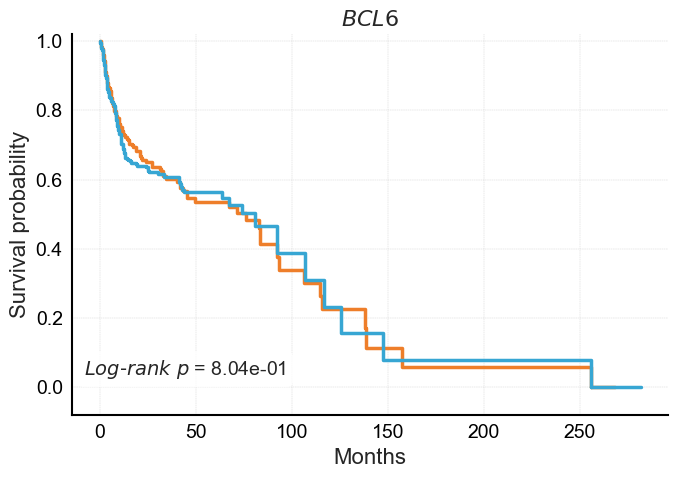

→ 完成：KM_BCL6_prob_fold4.pdf 已保存

---------- Risk table (first few rows) ----------
   time  High  Low
0     0   258  328
1    25   112  132
2    50    47   63
3    75    28   21
4   100    10    6
5   125     7    4
6   150     3    2
7   175     2    2
8   200     2    2
9   225     2    2
-----------------------------------------------
→ Risk table 已保存：evaluation/TCH_all/survival_singe_prob_DFS/RiskTable_BCL6_prob_fold4.csv


In [41]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
BH-TCH 生存分析（Overall Survival）
按模型预测风险（prob ≥ THR → High）分组，
一次性绘制 BCL2 / MYC / BCL6 共 3 张 KM 曲线。

依赖：
    pip install lifelines matplotlib pandas numpy openpyxl
"""

import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, statistics, CoxPHFitter
plt.rcParams.update({'font.family': 'Arial', 'font.size': 14,
                     'axes.labelsize': 16, 'xtick.labelsize': 14,
                     'ytick.labelsize': 14})

# --------------------------------------------------
# 0. 路径与参数
# --------------------------------------------------
fold        = 4
group_path  = './dataset_csv/BH_TCH(merge).xlsx'
pred_path   = f'./results/TCH_all/s_{fold}_checkpoint.csv'

out_dir     = Path('./evaluation/TCH_all/survival_singe_prob_DFS')
out_dir.mkdir(parents=True, exist_ok=True)

TIME_COL   = 'DFS(m)'       # 生存时间（月）---------★ 改这里
EVENT_COL  = 'DFS Status'   # 1 = 复发/死亡；0 = 随访/删失 ---★ 改这里
THR        = 0.5           # 概率阈值
gene       = 'BCL6'                                  # 指定基因

# --------------------------------------------------
# 1. 读取并合并
# --------------------------------------------------
group_df = pd.read_excel(group_path)
pred_df  = pd.read_csv(pred_path)

df = pred_df.merge(
        group_df[['slide_id', TIME_COL, EVENT_COL]],
        on='slide_id', how='left'
     ).dropna(subset=[TIME_COL, EVENT_COL])

# --------------------------------------------------
# 2. 分组函数
# --------------------------------------------------
def risk_group(prob, thr=THR):
    try:
        return 'High' if float(prob) >= thr else 'Low'
    except (ValueError, TypeError):
        return np.nan

# ---------- 高级 KM + rug 替换区（原脚本第 3 步） ----------
import seaborn as sns
from matplotlib import rcParams

# ---------- 单基因（BCL2）高级 KM（无 rug）----------
import seaborn as sns
from matplotlib import rcParams

rcParams['font.family'] = 'Arial'
sns.set_style("whitegrid", {'axes.grid': False})

fig, ax = plt.subplots(1, 1, figsize=(7, 5))   # 单图
prob_col = f'prob_{gene}'
df[f'{gene}_risk'] = df[prob_col].apply(risk_group)
sub = df.dropna(subset=[f'{gene}_risk'])

palette = {'High': '#EE7E2A', 'Low': '#37A6D3'}

# 绘制 KM
# for grp, g in sub.groupby(f'{gene}_risk'):
#     kmf = KaplanMeierFitter()
#     kmf.fit(g[TIME_COL], g[EVENT_COL], label=f'{grp} (N={len(g)})')
#     ax.plot(kmf.timeline, kmf.survival_function_.values,
#             color=palette[grp], lw=2.5)
#     # ax.fill_between(kmf.timeline,
#     #                 kmf.confidence_interval_.iloc[:, 0],
#     #                 kmf.confidence_interval_.iloc[:, 1],
#     #                 color=palette[grp], alpha=0.15)
for grp, g in sub.groupby(f'{gene}_risk'):
    kmf = KaplanMeierFitter()
    kmf.fit(g[TIME_COL], g[EVENT_COL])

    t = kmf.timeline
    s = kmf.survival_function_.values.flatten()

    ax.step(t, s, where='post',
            color=palette[grp], lw=2.5,
            label=f'{grp} (N={len(g)})')

    # 可选：把最后一条横线拉到图右边
    ax.plot([t[-1], ax.get_xlim()[1]], [s[-1], s[-1]],
            color=palette[grp], lw=2.5)

# log-rank p（科学计数法 + 大字体）
hi = sub.query(f'{gene}_risk=="High"')
lo = sub.query(f'{gene}_risk=="Low"')
lr_p = statistics.logrank_test(hi[TIME_COL], lo[TIME_COL],
                               hi[EVENT_COL], lo[EVENT_COL]).p_value
ax.text(0.02, 0.15, 
        r'$\it{Log{\text{-}}rank\ p}$' + f' = {lr_p:.2e}',
        transform=ax.transAxes,
        fontsize=14, verticalalignment='top',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

# 装饰
ax.set_title(r'$\mathit{' + gene + '}$', fontsize=16, style='italic')
ax.set_xlabel('Months')
ax.set_ylabel('Survival probability')
ax.set_ylim(-0.08, 1.02)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, axis='both', ls='--', lw=0.3, alpha=1.0)
# ↓↓↓ 加粗坐标轴 & 刻度 ↓↓↓
for spine in ['left', 'bottom']:
    ax.spines[spine].set_linewidth(1.5)
    ax.spines[spine].set_color('black')
ax.tick_params(width=1.5, colors='black')   # 刻度线黑色

plt.tight_layout()
plt.savefig(out_dir / f'KM_{gene}_prob_fold{fold}.pdf', dpi=300)
plt.show()
print(f'→ 完成：KM_{gene}_prob_fold{fold}.pdf 已保存')

# --------------------------------------------------
# 3. 生成并保存 risk table（Number at risk）
# --------------------------------------------------
risk_records = []          # 收集每一行
time_grid    = np.arange(0, int(sub[TIME_COL].max())+1, 25)  # 每 12 个月一个刻度，可改

for grp in ['Low', 'High']:
    g   = sub.query(f'{gene}_risk==@grp')
    kmf = KaplanMeierFitter()
    kmf.fit(g[TIME_COL], g[EVENT_COL], label=f'{grp}')
    
    # lifelines 自带 at-risk 表格
    atr = kmf.event_table[['at_risk']]
    atr = atr.reindex(time_grid, method='ffill').fillna(0).astype(int)
    atr['group'] = grp
    atr['time']  = atr.index
    risk_records.append(atr[['time', 'group', 'at_risk']])

risk_df = pd.concat(risk_records, ignore_index=True)\
          .pivot(index='time', columns='group', values='at_risk')\
          .rename_axis(None, axis=1)\
          .reset_index()

# 保存
risk_df.to_csv(out_dir / f'RiskTable_{gene}_prob_fold{fold}.csv', index=False)

print('\n---------- Risk table (first few rows) ----------')
print(risk_df.head(10))
print('-----------------------------------------------')
print(f'→ Risk table 已保存：'
      f'{out_dir}/RiskTable_{gene}_prob_fold{fold}.csv')


# 单表达 label DFS

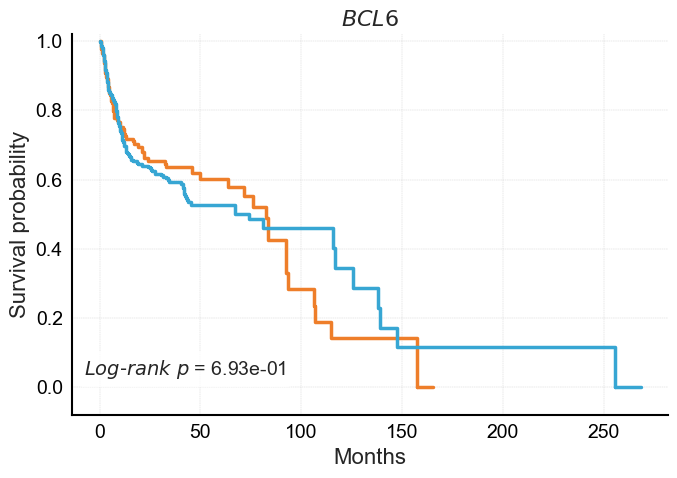

→ 完成：KM_BCL6_label.pdf 已保存

---------- Risk table (first few rows) ----------
   time  High  Low
0     0   173  413
1    25    78  166
2    50    34   76
3    75    20   29
4   100     7    9
5   125     4    7
6   150     2    3
7   175     1    3
8   200     1    3
9   225     1    3
-----------------------------------------------
→ Risk table 已保存：evaluation/TCH_all/survival_singe_label_DFS/RiskTable_BCL6_label_fold4.csv


In [90]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
BH-TCH 生存分析（Overall Survival）
按模型预测风险（prob ≥ THR → High）分组，
一次性绘制 BCL2 / MYC / BCL6 共 3 张 KM 曲线。

依赖：
    pip install lifelines matplotlib pandas numpy openpyxl
"""

import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, statistics, CoxPHFitter
plt.rcParams.update({'font.family': 'Arial', 'font.size': 14,
                     'axes.labelsize': 16, 'xtick.labelsize': 14,
                     'ytick.labelsize': 14})

# --------------------------------------------------
# 0. 路径与参数
# --------------------------------------------------
fold        = 4
group_path  = './dataset_csv/BH_TCH(merge).xlsx'
pred_path   = f'./results/TCH_all/s_{fold}_checkpoint.csv'

out_dir     = Path('./evaluation/TCH_all/survival_singe_label_DFS')
out_dir.mkdir(parents=True, exist_ok=True)

TIME_COL   = 'DFS(m)'       # 随访时间（月）
EVENT_COL  = 'DFS Status'   # 1 = 复发/死亡(事件)；0 = 随访/删失
THR        = 0.5           # 概率阈值
gene       = 'BCL6'                                  # 指定基因

# --------------------------------------------------
# 1. 读取并合并
# --------------------------------------------------
group_df = pd.read_excel(group_path)
pred_df  = pd.read_csv(pred_path)

df = pred_df.merge(
        group_df[['slide_id', TIME_COL, EVENT_COL]],
        on='slide_id', how='left'
     ).dropna(subset=[TIME_COL, EVENT_COL])

# --------------------------------------------------
# 2. 分组函数
# --------------------------------------------------
def risk_group(prob, thr=THR):
    try:
        return 'High' if float(prob) >= thr else 'Low'
    except (ValueError, TypeError):
        return np.nan

# ---------- 高级 KM + rug 替换区（原脚本第 3 步） ----------
import seaborn as sns
from matplotlib import rcParams

# ---------- 单基因（BCL2）高级 KM（无 rug）----------
import seaborn as sns
from matplotlib import rcParams

rcParams['font.family'] = 'Arial'
sns.set_style("whitegrid", {'axes.grid': False})

fig, ax = plt.subplots(1, 1, figsize=(7, 5))   # 单图
prob_col = f'label_{gene}'
df[f'{gene}_risk'] = df[prob_col].apply(risk_group)
sub = df.dropna(subset=[f'{gene}_risk'])

palette = {'High': '#EE7E2A', 'Low': '#37A6D3'}

# 绘制 KM
for grp, g in sub.groupby(f'{gene}_risk'):
    kmf = KaplanMeierFitter()
    kmf.fit(g[TIME_COL], g[EVENT_COL])

    t = kmf.timeline
    s = kmf.survival_function_.values.flatten()

    ax.step(t, s, where='post',
            color=palette[grp], lw=2.5,
            label=f'{grp} (N={len(g)})')

    # 可选：把最后一条横线拉到图右边
    ax.plot([t[-1], ax.get_xlim()[1]], [s[-1], s[-1]],
            color=palette[grp], lw=2.5)
    

# log-rank p（科学计数法 + 大字体）
hi = sub.query(f'{gene}_risk=="High"')
lo = sub.query(f'{gene}_risk=="Low"')
lr_p = statistics.logrank_test(hi[TIME_COL], lo[TIME_COL],
                               hi[EVENT_COL], lo[EVENT_COL]).p_value
ax.text(0.02, 0.15, 
        r'$\it{Log{\text{-}}rank\ p}$' + f' = {lr_p:.2e}',
        transform=ax.transAxes,
        fontsize=14, verticalalignment='top',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

# 装饰
ax.set_title(r'$\mathit{' + gene + '}$', fontsize=16, style='italic')
ax.set_xlabel('Months')
ax.set_ylabel('Survival probability')
ax.set_ylim(-0.08, 1.02)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, axis='both', ls='--', lw=0.3, alpha=1.0)
# ↓↓↓ 加粗坐标轴 & 刻度 ↓↓↓
for spine in ['left', 'bottom']:
    ax.spines[spine].set_linewidth(1.5)
    ax.spines[spine].set_color('black')
ax.tick_params(width=1.5, colors='black')   # 刻度线黑色

plt.tight_layout()
plt.savefig(out_dir / f'KM_{gene}_label.pdf', dpi=300)
plt.show()
print(f'→ 完成：KM_{gene}_label.pdf 已保存')

# --------------------------------------------------
# 3. 生成并保存 risk table（Number at risk）
# --------------------------------------------------
risk_records = []          # 收集每一行
time_grid    = np.arange(0, int(sub[TIME_COL].max())+1, 25)  # 每 12 个月一个刻度，可改

for grp in ['Low', 'High']:
    g   = sub.query(f'{gene}_risk==@grp')
    kmf = KaplanMeierFitter()
    kmf.fit(g[TIME_COL], g[EVENT_COL], label=f'{grp}')
    
    # lifelines 自带 at-risk 表格
    atr = kmf.event_table[['at_risk']]
    atr = atr.reindex(time_grid, method='ffill').fillna(0).astype(int)
    atr['group'] = grp
    atr['time']  = atr.index
    risk_records.append(atr[['time', 'group', 'at_risk']])

risk_df = pd.concat(risk_records, ignore_index=True)\
          .pivot(index='time', columns='group', values='at_risk')\
          .rename_axis(None, axis=1)\
          .reset_index()

# 保存
risk_df.to_csv(out_dir / f'RiskTable_{gene}_label_fold{fold}.csv', index=False)

print('\n---------- Risk table (first few rows) ----------')
print(risk_df.head(10))
print('-----------------------------------------------')
print(f'→ Risk table 已保存：'
      f'{out_dir}/RiskTable_{gene}_label_fold{fold}.csv')


# 共表达label OS预测

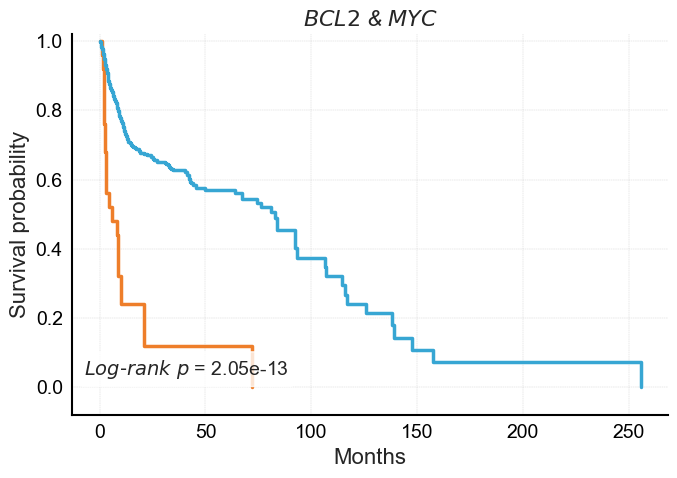

→ 完成：KM_BCL2_MYC_coexpr_DFS.pdf 已保存
---------- Risk table ----------
   time  High  Low
0     0    25  561
1    25     4  241
2    50     2  108
3    75     1   48
4   100     1   15
5   125     1   10
6   150     1    4
7   175     1    3
8   200     1    3
9   225     1    3
--------------------------------


In [2]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
BH-TCH 共表达生存分析（DFS，label 版）
一次只画一对基因（BCL2 & MYC），单独出图 + risk table
"""
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, statistics
import seaborn as sns
from matplotlib import rcParams

# ---------- 0. 基础设置 ----------
plt.rcParams.update({'font.family': 'Arial', 'font.size': 14,
                     'axes.labelsize': 16, 'xtick.labelsize': 14,
                     'ytick.labelsize': 14})
rcParams['font.family'] = 'Arial'
sns.set_style("whitegrid", {'axes.grid': False})

# ---------- 1. 路径与参数 ----------
fold        = 4
group_path  = './dataset_csv/BH_TCH(merge).xlsx'
pred_path   = f'./results/TCH_all/s_{fold}_checkpoint.csv'
out_dir     = Path('./evaluation/TCH_all/survival_double_label_DFS')
out_dir.mkdir(parents=True, exist_ok=True)

TIME_COL   = 'DFS(m)'        # 或 'DFS(m)'
EVENT_COL  = 'DFS Status'    # 或 'DFS Status'
THR        = 0.5              # label 阈值：1=阳性，0=阴性
gene_pairs = [('BCL2',  'MYC')]   # 只画一对，可扩展

# ---------- 2. 读取并合并 ----------
group_df = pd.read_excel(group_path)
pred_df  = pd.read_csv(pred_path)
df = (pred_df
      .merge(group_df[['slide_id', TIME_COL, EVENT_COL]], on='slide_id', how='left')
      .dropna(subset=[TIME_COL, EVENT_COL]))

# ---------- 3. 共表达 risk 列生成 ----------
def risk_group_pair(lbl1, lbl2, thr=THR):
    try:
        return 'High' if (float(lbl1) >= thr and float(lbl2) >= thr) else 'Low'
    except (ValueError, TypeError):
        return np.nan

for g1, g2 in gene_pairs:
    col1, col2 = f'label_{g1}', f'label_{g2}'
    for c in (col1, col2):
        if c not in df.columns:
            raise ValueError(f'缺失列 {c}，请检查预测文件')
    df[f'{g1}_{g2}_risk'] = df.apply(
        lambda row: risk_group_pair(row[col1], row[col2]), axis=1)

# ---------- 4. 画图 + risk table ----------
palette = {'High': '#EE7E2A', 'Low': '#37A6D3'}

for g1, g2 in gene_pairs:
    risk_col = f'{g1}_{g2}_risk'
    sub      = df.dropna(subset=[risk_col])

    fig, ax = plt.subplots(1, 1, figsize=(7, 5))

    # KM 曲线
    for grp, g in sub.groupby(risk_col):
        kmf = KaplanMeierFitter()
        kmf.fit(g[TIME_COL], g[EVENT_COL], label=f'{grp} (N={len(g)})')
        ax.step(kmf.timeline, kmf.survival_function_.values, where='post',
                color=palette[grp], lw=2.5)

    # 斜体 Log-rank p
    hi, lo = sub.query(f'{risk_col}=="High"'), sub.query(f'{risk_col}=="Low"')
    lr_p   = statistics.logrank_test(
                hi[TIME_COL], lo[TIME_COL], hi[EVENT_COL], lo[EVENT_COL]).p_value
    ax.text(0.02, 0.15,
            r'$\it{Log{\text{-}}rank\ p}$' + f' = {lr_p:.2e}',
            transform=ax.transAxes, fontsize=14, verticalalignment='top',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

    # 装饰
    ax.set_title(r'$\mathit{' + f'{g1}' + r'}$ & $\mathit{' + f'{g2}' + r'}$',
                 fontsize=16, style='italic')
    ax.set_xlabel('Months')
    ax.set_ylabel('Survival probability')
    ax.set_ylim(-0.08, 1.02)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(True, axis='both', ls='--', lw=0.3, alpha=1.0)
    for spine in ['left', 'bottom']:
        ax.spines[spine].set_linewidth(1.5)
        ax.spines[spine].set_color('black')
    ax.tick_params(width=1.5, colors='black')

    plt.tight_layout()
    out_pdf = out_dir / f'KM_{g1}_{g2}_coexpr_DFS.pdf'
    plt.savefig(out_pdf, dpi=300)
    plt.show()
    print(f'→ 完成：{out_pdf.name} 已保存')

    # ---------- 5. risk table ----------
    time_grid = np.arange(0, int(sub[TIME_COL].max()) + 1, 25)
    risk_rows = []
    for grp in ['Low', 'High']:
        g   = sub.query(f'{risk_col}==@grp')
        kmf = KaplanMeierFitter()
        kmf.fit(g[TIME_COL], g[EVENT_COL])
        atr = kmf.event_table[['at_risk']].reindex(time_grid, method='ffill')\
                 .fillna(0).astype(int)
        atr['group'] = grp
        atr['time']  = atr.index
        risk_rows.append(atr[['time', 'group', 'at_risk']])
        
    
    risk_df = (pd.concat(risk_rows, ignore_index=True)
                 .pivot(index='time', columns='group', values='at_risk')
                 .rename_axis(None, axis=1)
                 .reset_index())
    risk_df.to_csv(out_dir / f'RiskTable_{g1}_{g2}_coexpr_DFS.csv',
                   index=False)
    print('---------- Risk table ----------')
    print(risk_df.head(10))
    print('--------------------------------')

# double prob

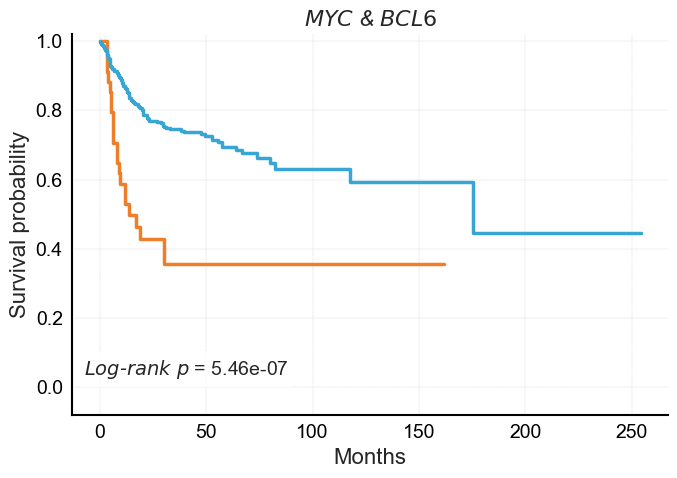

→ 完成：KM_MYC_BCL6_coexpr_OS_fold4.pdf 已保存
---------- Risk table ----------
   time  High  Low
0     0    34  552
1    25    10  268
2    50     5  126
3    75     4   53
4   100     3   20
5   125     2   12
6   150     2    7
7   175     1    5
8   200     1    3
9   225     1    3
--------------------------------


In [3]:
# #!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
BH-TCH 共表达生存分析（DFS，label 版）
一次只画一对基因（BCL2 & MYC），单独出图 + risk table
"""
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, statistics
import seaborn as sns
from matplotlib import rcParams

# ---------- 0. 基础设置 ----------
plt.rcParams.update({'font.family': 'Arial', 'font.size': 14,
                     'axes.labelsize': 16, 'xtick.labelsize': 14,
                     'ytick.labelsize': 14})
rcParams['font.family'] = 'Arial'
sns.set_style("whitegrid", {'axes.grid': False})

# ---------- 1. 路径与参数 ----------
fold        = 4
group_path  = './dataset_csv/BH_TCH(merge).xlsx'
pred_path   = f'./results/TCH_all/s_{fold}_checkpoint.csv'
out_dir     = Path('./evaluation/TCH_all/survival_double_prob_OS')
out_dir.mkdir(parents=True, exist_ok=True)

TIME_COL   = 'OS(m)'        # 或 'DFS(m)'
EVENT_COL  = 'OS Status'    # 或 'DFS Status'
THR        = 0.5              # label 阈值：1=阳性，0=阴性
gene_pairs = [('MYC',  'BCL6')]   # 只画一对，可扩展

# ---------- 2. 读取并合并 ----------
group_df = pd.read_excel(group_path)
pred_df  = pd.read_csv(pred_path)
df = (pred_df
      .merge(group_df[['slide_id', TIME_COL, EVENT_COL]], on='slide_id', how='left')
      .dropna(subset=[TIME_COL, EVENT_COL]))

# ---------- 3. 共表达 risk 列生成 ----------
def risk_group_pair(lbl1, lbl2, thr=THR):
    try:
        return 'High' if (float(lbl1) >= thr and float(lbl2) >= thr) else 'Low'
    except (ValueError, TypeError):
        return np.nan

for g1, g2 in gene_pairs:
    col1, col2 = f'prob_{g1}', f'prob_{g2}'
    for c in (col1, col2):
        if c not in df.columns:
            raise ValueError(f'缺失列 {c}，请检查预测文件')
    df[f'{g1}_{g2}_risk'] = df.apply(
        lambda row: risk_group_pair(row[col1], row[col2]), axis=1)

# ---------- 4. 画图 + risk table ----------
palette = {'High': '#EE7E2A', 'Low': '#37A6D3'}

for g1, g2 in gene_pairs:
    risk_col = f'{g1}_{g2}_risk'
    sub      = df.dropna(subset=[risk_col])

    fig, ax = plt.subplots(1, 1, figsize=(7, 5))

    # KM 曲线
    for grp, g in sub.groupby(risk_col):
        kmf = KaplanMeierFitter()
        kmf.fit(g[TIME_COL], g[EVENT_COL], label=f'{grp} (N={len(g)})')
        ax.step(kmf.timeline, kmf.survival_function_.values, where='post',
                color=palette[grp], lw=2.5)

    # 斜体 Log-rank p
    hi, lo = sub.query(f'{risk_col}=="High"'), sub.query(f'{risk_col}=="Low"')
    lr_p   = statistics.logrank_test(
                hi[TIME_COL], lo[TIME_COL], hi[EVENT_COL], lo[EVENT_COL]).p_value
    ax.text(0.02, 0.15,
            r'$\it{Log{\text{-}}rank\ p}$' + f' = {lr_p:.2e}',
            transform=ax.transAxes, fontsize=14, verticalalignment='top',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

    # 装饰
    ax.set_title(r'$\mathit{' + f'{g1}' + r'}$ & $\mathit{' + f'{g2}' + r'}$',
                 fontsize=16, style='italic')
    ax.set_xlabel('Months')
    ax.set_ylabel('Survival probability')
    ax.set_ylim(-0.08, 1.02)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(True, axis='both', ls='--', lw=0.3, alpha=1.0)
    for spine in ['left', 'bottom']:
        ax.spines[spine].set_linewidth(1.5)
        ax.spines[spine].set_color('black')
    ax.tick_params(width=1.5, colors='black')

    plt.tight_layout()
    out_pdf = out_dir / f'KM_{g1}_{g2}_coexpr_OS_fold{fold}.pdf'
    plt.savefig(out_pdf, dpi=300)
    plt.show()
    print(f'→ 完成：{out_pdf.name} 已保存')

    # ---------- 5. risk table ----------
    time_grid = np.arange(0, int(sub[TIME_COL].max()) + 1, 25)
    risk_rows = []
    for grp in ['Low', 'High']:
        g   = sub.query(f'{risk_col}==@grp')
        kmf = KaplanMeierFitter()
        kmf.fit(g[TIME_COL], g[EVENT_COL])
        atr = kmf.event_table[['at_risk']].reindex(time_grid, method='ffill')\
                 .fillna(0).astype(int)
        atr['group'] = grp
        atr['time']  = atr.index
        risk_rows.append(atr[['time', 'group', 'at_risk']])

    risk_df = (pd.concat(risk_rows, ignore_index=True)
                 .pivot(index='time', columns='group', values='at_risk')
                 .rename_axis(None, axis=1)
                 .reset_index())
    risk_df.to_csv(out_dir / f'RiskTable_{g1}_{g2}_coexpr_OS_fold{fold}.csv',
                   index=False)
    print('---------- Risk table ----------')
    print(risk_df.head(10))
    print('--------------------------------')

# 三表达 prob

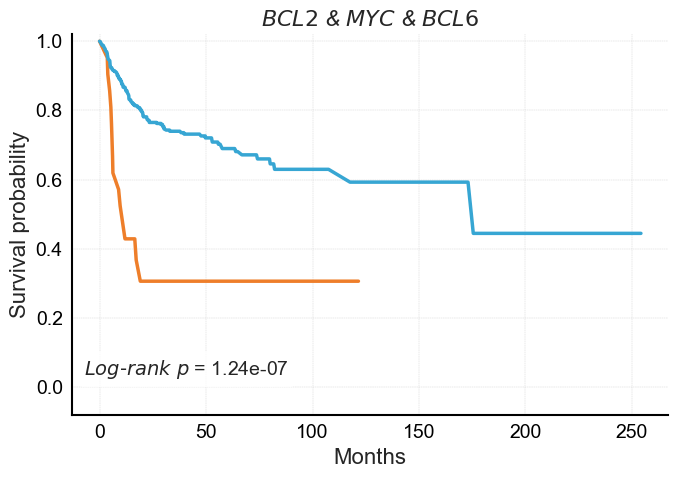

→ 完成：KM_BCL2_MYC_BCL6_triple_prob_OS_fold4.pdf 已保存

---------- Risk table ----------
   time  High  Low
0     0    21  565
1    25     5  274
2    50     3  128
3    75     2   55
4   100     2   21
5   125     1   13
6   150     1    8
7   175     1    5
8   200     1    3
9   225     1    3
--------------------------------
→ Risk table 已保存：evaluation/TCH_all/survival_triple_prob_OS/RiskTable_BCL2_MYC_BCL6_triple_prob_OS_fold4.csv


In [83]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
BH-TCH 三表达生存分析（DFS，prob 版）
High：三张片 prob 均 ≥ THR；其余为 Low
"""
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, statistics
import seaborn as sns
from matplotlib import rcParams

# ---------- 0. 基础设置 ----------
plt.rcParams.update({'font.family': 'Arial', 'font.size': 14,
                     'axes.labelsize': 16, 'xtick.labelsize': 14,
                     'ytick.labelsize': 14})
rcParams['font.family'] = 'Arial'
sns.set_style("whitegrid", {'axes.grid': False})

# ---------- 1. 路径与参数 ----------
fold       = 4
group_path = './dataset_csv/BH_TCH(merge).xlsx'
pred_path  = f'./results/TCH_all/s_{fold}_checkpoint.csv'
out_dir    = Path('./evaluation/TCH_all/survival_triple_prob_OS')
out_dir.mkdir(parents=True, exist_ok=True)

TIME_COL   = 'OS(m)'
EVENT_COL  = 'OS Status'
THR        = 0.5
genes      = ['BCL2', 'MYC', 'BCL6']   # 三表达基因

# ---------- 2. 读取并合并 ----------
group_df = pd.read_excel(group_path)
pred_df  = pd.read_csv(pred_path)
df = (pred_df
      .merge(group_df[['slide_id', TIME_COL, EVENT_COL]], on='slide_id', how='left')
      .dropna(subset=[TIME_COL, EVENT_COL]))

# ---------- 3. 三表达 risk 列 ----------
prob_cols = [f'prob_{g}' for g in genes]
for c in prob_cols:
    if c not in df.columns:
        raise ValueError(f'缺失列 {c}')

df['triple_risk'] = (df[prob_cols] >= THR).all(axis=1)\
                      .map({True: 'High', False: 'Low'})

# ---------- 4. 画图 ----------
palette = {'High': '#EE7E2A', 'Low': '#37A6D3'}
sub     = df.dropna(subset=['triple_risk'])

fig, ax = plt.subplots(1, 1, figsize=(7, 5))

for grp, g in sub.groupby('triple_risk'):
    kmf = KaplanMeierFitter()
    kmf.fit(g[TIME_COL], g[EVENT_COL], label=f'{grp} (N={len(g)})')
    ax.plot(kmf.timeline, kmf.survival_function_.values,
            color=palette[grp], lw=2.5)

# 斜体 p
hi, lo = sub.query('triple_risk=="High"'), sub.query('triple_risk=="Low"')
lr_p   = statistics.logrank_test(
            hi[TIME_COL], lo[TIME_COL], hi[EVENT_COL], lo[EVENT_COL]).p_value
ax.text(0.02, 0.15,
        r'$\it{Log{\text{-}}rank\ p}$' + f' = {lr_p:.2e}',
        transform=ax.transAxes, fontsize=14, verticalalignment='top',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

# 装饰
ax.set_title(r'$\mathit{BCL2}$ & $\mathit{MYC}$ & $\mathit{BCL6}$',
             fontsize=16, style='italic')
ax.set_xlabel('Months')
ax.set_ylabel('Survival probability')
ax.set_ylim(-0.08, 1.02)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, axis='both', ls='--', lw=0.3, alpha=1.0)
for spine in ['left', 'bottom']:
    ax.spines[spine].set_linewidth(1.5)
    ax.spines[spine].set_color('black')
ax.tick_params(width=1.5, colors='black')

plt.tight_layout()
out_pdf = out_dir / f'KM_BCL2_MYC_BCL6_triple_prob_OS_fold{fold}.pdf'
plt.savefig(out_pdf, dpi=300)
plt.show()
print(f'→ 完成：{out_pdf.name} 已保存')

# ---------- 5. risk table ----------
time_grid = np.arange(0, int(sub[TIME_COL].max()) + 1, 25)
risk_rows = []
for grp in ['Low', 'High']:
    g   = sub.query(f'triple_risk==@grp')
    kmf = KaplanMeierFitter()
    kmf.fit(g[TIME_COL], g[EVENT_COL])
    atr = kmf.event_table[['at_risk']].reindex(time_grid, method='ffill')\
             .fillna(0).astype(int)
    atr['group'] = grp
    atr['time']  = atr.index
    risk_rows.append(atr[['time', 'group', 'at_risk']])

risk_df = (pd.concat(risk_rows, ignore_index=True)
             .pivot(index='time', columns='group', values='at_risk')
             .rename_axis(None, axis=1)
             .reset_index())
risk_df.to_csv(out_dir / f'RiskTable_BCL2_MYC_BCL6_triple_prob_OS_fold{fold}.csv',
               index=False)

print('\n---------- Risk table ----------')
print(risk_df.head(10))
print('--------------------------------')
print(f'→ Risk table 已保存：{out_dir}/RiskTable_BCL2_MYC_BCL6_triple_prob_OS_fold{fold}.csv')

# 3表达 label

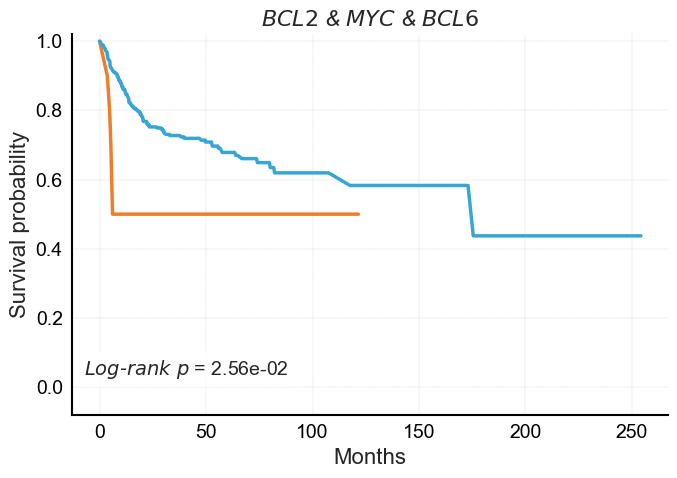

→ 完成：KM_BCL2_MYC_BCL6_triple_prob_OS_fold4.pdf 已保存

---------- Risk table ----------
   time  High  Low
0     0    10  576
1    25     4  275
2    50     2  129
3    75     2   55
4   100     2   21
5   125     1   13
6   150     1    8
7   175     1    5
8   200     1    3
9   225     1    3
--------------------------------
→ Risk table 已保存：evaluation/TCH_all/survival_triple_label_OS/RiskTable_BCL2_MYC_BCL6_triple_label_OS.csv


In [87]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
BH-TCH 三表达生存分析（DFS，prob 版）
High：三张片 prob 均 ≥ THR；其余为 Low
"""
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, statistics
import seaborn as sns
from matplotlib import rcParams

# ---------- 0. 基础设置 ----------
plt.rcParams.update({'font.family': 'Arial', 'font.size': 14,
                     'axes.labelsize': 16, 'xtick.labelsize': 14,
                     'ytick.labelsize': 14})
rcParams['font.family'] = 'Arial'
sns.set_style("whitegrid", {'axes.grid': False})

# ---------- 1. 路径与参数 ----------
fold       = 4
group_path = './dataset_csv/BH_TCH(merge).xlsx'
pred_path  = f'./results/TCH_all/s_{fold}_checkpoint.csv'
out_dir    = Path('./evaluation/TCH_all/survival_triple_label_OS')
out_dir.mkdir(parents=True, exist_ok=True)

TIME_COL   = 'OS(m)'
EVENT_COL  = 'OS Status'
THR        = 0.5
genes      = ['BCL2', 'MYC', 'BCL6']   # 三表达基因

# ---------- 2. 读取并合并 ----------
group_df = pd.read_excel(group_path)
pred_df  = pd.read_csv(pred_path)
df = (pred_df
      .merge(group_df[['slide_id', TIME_COL, EVENT_COL]], on='slide_id', how='left')
      .dropna(subset=[TIME_COL, EVENT_COL]))

# ---------- 3. 三表达 risk 列 ----------
prob_cols = [f'label_{g}' for g in genes]
for c in prob_cols:
    if c not in df.columns:
        raise ValueError(f'缺失列 {c}')

df['triple_risk'] = (df[prob_cols] >= THR).all(axis=1)\
                      .map({True: 'High', False: 'Low'})

# ---------- 4. 画图 ----------
palette = {'High': '#EE7E2A', 'Low': '#37A6D3'}
sub     = df.dropna(subset=['triple_risk'])

fig, ax = plt.subplots(1, 1, figsize=(7, 5))

for grp, g in sub.groupby('triple_risk'):
    kmf = KaplanMeierFitter()
    kmf.fit(g[TIME_COL], g[EVENT_COL], label=f'{grp} (N={len(g)})')
    ax.plot(kmf.timeline, kmf.survival_function_.values,
            color=palette[grp], lw=2.5)

# 斜体 p
hi, lo = sub.query('triple_risk=="High"'), sub.query('triple_risk=="Low"')
lr_p   = statistics.logrank_test(
            hi[TIME_COL], lo[TIME_COL], hi[EVENT_COL], lo[EVENT_COL]).p_value
ax.text(0.02, 0.15,
        r'$\it{Log{\text{-}}rank\ p}$' + f' = {lr_p:.2e}',
        transform=ax.transAxes, fontsize=14, verticalalignment='top',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

# 装饰
ax.set_title(r'$\mathit{BCL2}$ & $\mathit{MYC}$ & $\mathit{BCL6}$',
             fontsize=16, style='italic')
ax.set_xlabel('Months')
ax.set_ylabel('Survival probability')
ax.set_ylim(-0.08, 1.02)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, axis='both', ls='--', lw=0.3, alpha=1.0)
for spine in ['left', 'bottom']:
    ax.spines[spine].set_linewidth(1.5)
    ax.spines[spine].set_color('black')
ax.tick_params(width=1.5, colors='black')

plt.tight_layout()
out_pdf = out_dir / f'KM_BCL2_MYC_BCL6_triple_prob_OS_fold{fold}.pdf'
plt.savefig(out_pdf, dpi=300)
plt.show()
print(f'→ 完成：{out_pdf.name} 已保存')

# ---------- 5. risk table ----------
time_grid = np.arange(0, int(sub[TIME_COL].max()) + 1, 25)
risk_rows = []
for grp in ['Low', 'High']:
    g   = sub.query(f'triple_risk==@grp')
    kmf = KaplanMeierFitter()
    kmf.fit(g[TIME_COL], g[EVENT_COL])
    atr = kmf.event_table[['at_risk']].reindex(time_grid, method='ffill')\
             .fillna(0).astype(int)
    atr['group'] = grp
    atr['time']  = atr.index
    risk_rows.append(atr[['time', 'group', 'at_risk']])

risk_df = (pd.concat(risk_rows, ignore_index=True)
             .pivot(index='time', columns='group', values='at_risk')
             .rename_axis(None, axis=1)
             .reset_index())
risk_df.to_csv(out_dir / f'RiskTable_BCL2_MYC_BCL6_triple_label_OS.csv',
               index=False)

print('\n---------- Risk table ----------')
print(risk_df.head(10))
print('--------------------------------')
print(f'→ Risk table 已保存：{out_dir}/RiskTable_BCL2_MYC_BCL6_triple_label_OS.csv')